In [1]:
import l2f_tda as tda
import numpy as np
import pandas as pd
import datetime as dt
import gudhi as gd
import sklearn as sk
import dask_ml as daml
import pickle as pkl

import matplotlib.pyplot as plt
%matplotlib inline

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import sklearn.utils as skutils
from sklearn.model_selection import TimeSeriesSplit, KFold
import sklearn.preprocessing as skprep
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from keras.models import Sequential
import keras.layers as klayers
import keras.optimizers as koptimizers
import keras.callbacks as kcallbacks
from keras.wrappers.scikit_learn import KerasRegressor

Using TensorFlow backend.


In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1" 

In [3]:
import keras
import tensorflow as tf

config = tf.ConfigProto( device_count = {'CPU': 48} ) 
config = tf.ConfigProto( device_count = {'GPU': 1} ) 

sess = tf.Session(config=config) 
keras.backend.set_session(sess)

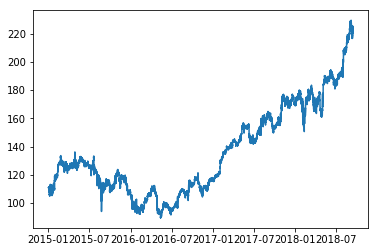

In [4]:
data = pd.read_csv('AAPL.csv', names=['time', 'price'], parse_dates=['time'])

data.time = pd.to_datetime(data.time, utc=True)
data.time = data.time.dt.tz_convert(tz='America/New_York')
data.time = data.time.dt.tz_localize(None)
data.set_index('time', drop=True, inplace=True)
data.columns = range(1)
plt.plot(data)

/home/shared_envs/research_env/lib/python3.6/site-packages/pandas/core/indexing.py:635: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



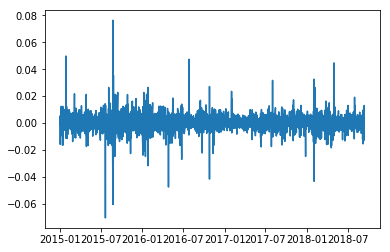

In [5]:
samplingTimeList = [ dt.time(i, 30, 0) for i in range(9, 20, 1) ] + [ dt.time(i, 0, 0) for i in range(9, 20, 1) ]
sampling = tda.Sampler(transformationType='return', removeWeekends=True, samplingType = 'fixed', samplingTimeList=samplingTimeList)
data = sampling.fit(data).transform(data)
plt.plot(data[0])

In [6]:
numberTrain = data[0].shape[0] * 3 // 4
X_train = data[0][:numberTrain]
y_train = np.empty((X_train.shape[0], 1))
print(X_train.shape)
X_train.head(10)

(15699,)


time
2014-12-31 19:30:00   -0.000181
2015-01-02 09:00:00    0.005509
2015-01-02 09:30:00   -0.000898
2015-01-02 10:00:00   -0.015732
2015-01-02 10:30:00   -0.003288
2015-01-02 11:00:00   -0.008980
2015-01-02 11:30:00    0.002959
2015-01-02 12:00:00    0.003227
2015-01-02 12:30:00    0.003676
2015-01-02 13:00:00    0.001648
Name: 0, dtype: float64

In [7]:
numberTest = data[0].shape[0] // 4
X_test = data[0][numberTrain:numberTrain+numberTest]
y_test = np.empty((X_test.shape[0], 1))
X_test.head()

time
2017-10-16 10:30:00    0.000502
2017-10-16 11:00:00   -0.000439
2017-10-16 11:30:00    0.000251
2017-10-16 12:00:00    0.000251
2017-10-16 12:30:00   -0.001632
Name: 0, dtype: float64

In [8]:
steps = [
#     ('sampling', tda.Sampler(transformationType='return', removeWeekends=True, samplingType = 'fixed', samplingTimeList=samplingTimeList)),
    ('embedding', tda.TakensEmbedder()),
    ('labelling', tda.Labeller(labellingType='variation', function = np.std)),
    ('diagram', tda.VietorisRipsDiagram()),
    ('distance', tda.DiagramDistance()),
    ('physical', tda.MDS()),
    ('derivatives', tda.Derivatives()),
    ('scaling', tda.ScalerWrapper(copy=True)),
    ('formulation', tda.FormulationTransformer()),
    ('regression', tda.KerasRegressorWrapper())
]

pipeline_transform = Pipeline(steps[:-1])
pipeline_estimate = Pipeline([steps[-1]])

pipeline = Pipeline(steps)

In [9]:
pipeline_transform.get_params()
pipeline_estimate.get_params()
pipeline.get_params()

{'memory': None,
 'steps': [('embedding',
   TakensEmbedder(innerWindowDuration=5, innerWindowStride=1,
           outerWindowDuration=20, outerWindowStride=2)),
  ('labelling', Labeller(deltaT=0, function=<function std at 0x7fda6c0b5b70>,
        labellingType='variation')),
  ('diagram', VietorisRipsDiagram(dataType='points', doPadding=True,
             homologyDimensions=[0, 1], maxEdgeLength=inf, n_jobs=1)),
  ('distance',
   DiagramDistance(metric_kwargs={'metric': 'bottleneck'}, n_jobs=1, order=inf,
           separateDimensions=False)),
  ('physical',
   MDS(dissimilarity='precomputed', eps=0.001, max_iter=300, metric=True,
     n_components=2, n_init=4, n_jobs=None, random_state=None, verbose=0)),
  ('derivatives', Derivatives(orders=[0, 1, 2])),
  ('scaling', ScalerWrapper(copy=True, feature_range=(0, 1))),
  ('formulation',
   FormulationTransformer(numberStepsInPast=10, stepInFuture=1)),
  ('regression',
   <l2f_tda.KerasWrapper.KerasRegressorWrapper at 0x7fd83c4caac8>)],
 

In [ ]:
# Sampling
sampling_param = {}
sampling_param_grid = {'sampling__' + k: v for k, v in sampling_param.items()}

# Embedding
embedding_param = {}
embedding_param['outerWindowDuration'] = [ 100, 200 ]
embedding_param['outerWindowStride'] = [ 10, 20 ]
embedding_param['innerWindowDuration'] = [ 10, 40 ]
embedding_param['innerWindowStride'] = [ 1 ]
embedding_param_grid = {'embedding__' + k: v for k, v in embedding_param.items()}

# Labelling
labelling_param = {}
labelling_param['deltaT'] = [ 10 ]
labelling_param_grid = {'labelling__' + k: v for k, v in labelling_param.items()}

# Diagram
diagram_param = {}
diagram_param['homologyDimensions'] = [ [ 0, 1 ] ]
diagram_param_grid = {'diagram__' + k: v for k, v in diagram_param.items()}

# Distance
distance_param = {}
distance_param['metric_kwargs'] = [ {'metric':'landscape', 'n_layers':1, 'n_samples':1000, 'order':2}, 
                                    {'metric':'betti', 'n_samples':1000}, 
                                    {'metric':'bottleneck'}, {'metric':'wasserstein', 'order':2} ]
distance_param_grid = {'distance__' + k: v for k, v in distance_param.items()}

# Physical
physical_param = {}
physical_param['n_components'] = [ 10 ]
physical_param_grid = {'physical__' + k: v for k, v in physical_param.items()}

# Derivatives
derivatives_param = {}
derivatives_param['orders'] = [ [0, 1, 2] ]
derivatives_param_grid = {'derivatives__' + k: v for k, v in derivatives_param.items()}

# Scaling
scaling_param = {}
# scaling_param['scaler'] = [ skprep.MinMaxScaler, skprep.StandardScaler ]
scaling_param_grid = {'scaling__' + k: v for k, v in scaling_param.items()}

# Formulation
formulation_param = {}
formulation_param['numberStepsInPast'] = [ 20 ]
formulation_param['stepInFuture'] = [ 1 ]
formulation_param_grid = {'formulation__' + k: v for k, v in formulation_param.items()}

# Regression
regression_param = {}
regression_param['numberFeatures'] =  [ physical_param['n_components'][0] *  len(derivatives_param['orders'][0]) ]
regression_param['numberStepsInPast'] =  formulation_param['numberStepsInPast']
regression_param['modelSteps'] = [ 
    [
        {'layerClass': klayers.normalization.BatchNormalization},
        {'layerClass': klayers.Dropout, 'rate': rateInput},
        {'layerClass': layerClass, 'units': units, 'activation': 'tanh'},
        {'layerClass': klayers.Dropout, 'rate': rateLSTM},
        {'layerClass': klayers.Dense, 'units': 1, 'use_bias': False}
] for layerClass in [klayers.LSTM] for units in [4, 16] for rateInput in [0.1, 0.2] for rateLSTM in [0.1, 0.2]] +\
[ [
        {'layerClass': klayers.normalization.BatchNormalization},
        {'layerClass': klayers.Dropout, 'rate': rateInput},
        {'layerClass': layerClass, 'units': units, 'activation': 'tanh'},
        {'layerClass': klayers.Dropout, 'rate': rateLSTM1},
        {'layerClass': layerClass, 'units': units, 'activation': 'tanh'},
        {'layerClass': klayers.Dense, 'units': 1}
] for layerClass in [klayers.LSTM] for units in [2, 8] for rateInput in [0.1, 0.2] for rateLSTM1 in [0.1, 0.2] ]

regression_param['optimizerClass'] = [ koptimizers.RMSprop, koptimizers.Adam ]
regression_param['optimizer_kwargs'] = [ {'lr': lr}
                                         for lr in [0.001, 0.01] ]
# regression_param['callbacks'] = [ [kcallbacks.ModelCheckpoint('./model.sk', monitor='loss', save_best_only=True)] ]
regression_param['loss'] = [ 'mean_squared_error' ]
regression_param['batch_size'] =  [ 100, 500 ]
regression_param['epochs'] =  [ 8000 ]
regression_param_grid = {'regression__' + k: v for k, v in regression_param.items()}


param_grid_transform = {**sampling_param_grid, **embedding_param_grid, **labelling_param_grid, **diagram_param_grid, **distance_param_grid, 
              **physical_param_grid, **derivatives_param_grid, **scaling_param_grid, **formulation_param_grid}
param_grid_transform['diagram__n_jobs'] = [24]
param_grid_transform['distance__n_jobs'] = [24]

param_grid_estimate = {**regression_param_grid}
param_grid = {**param_grid_transform, ** param_grid_estimate}
# print(param_grid_transform)
# print(param_grid_estimate)

In [ ]:
from dask_ml.model_selection import GridSearchCV
from sklearn.model_selection import GridSearchCV

# from dask.distributed import Client
# client = Client()
# skutils.parallel_backend(backend='multiprocessing')

In [13]:
%%time

cv = TimeSeriesSplit(n_splits=2)
grid = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=cv, n_jobs=24, pre_dispatch='2*n_jobs', verbose=100, error_score='raise') #iid=False ???
grid_result = grid.fit(X_train, X_train)


Fitting 2 folds for each of 4096 candidates, totalling 8192 fits
[Parallel(n_jobs=24)]: Using backend LokyBackend with 24 concurrent workers.
Pickling array (shape=(15699,), dtype=datetime64[ns]).
Pickling array (shape=(15699,), dtype=float64).
Pickling array (shape=(15699,), dtype=datetime64[ns]).
Pickling array (shape=(5233,), dtype=int64).
Pickling array (shape=(5233,), dtype=int64).
Pickling array (shape=(15699,), dtype=datetime64[ns]).
Pickling array (shape=(15699,), dtype=float64).
Pickling array (shape=(15699,), dtype=datetime64[ns]).
Pickling array (shape=(10466,), dtype=int64).
Pickling array (shape=(5233,), dtype=int64).
Pickling array (shape=(15699,), dtype=datetime64[ns]).
Pickling array (shape=(15699,), dtype=float64).
Pickling array (shape=(15699,), dtype=datetime64[ns]).
Pickling array (shape=(5233,), dtype=int64).
Pickling array (shape=(5233,), dtype=int64).
Pickling array (shape=(15699,), dtype=datetime64[ns]).
Pickling array (shape=(15699,), dtype=float64).
Pickling a

[Parallel(n_jobs=24)]: Done   7 tasks      | elapsed: 140.0min
Pickling array (shape=(15699,), dtype=datetime64[ns]).
Pickling array (shape=(15699,), dtype=float64).
Pickling array (shape=(15699,), dtype=datetime64[ns]).
Pickling array (shape=(10466,), dtype=int64).
Pickling array (shape=(5233,), dtype=int64).
[Parallel(n_jobs=24)]: Done   8 tasks      | elapsed: 143.4min
Pickling array (shape=(15699,), dtype=datetime64[ns]).
Pickling array (shape=(15699,), dtype=float64).
Pickling array (shape=(15699,), dtype=datetime64[ns]).
Pickling array (shape=(5233,), dtype=int64).
Pickling array (shape=(5233,), dtype=int64).
[Parallel(n_jobs=24)]: Done   9 tasks      | elapsed: 143.7min
Pickling array (shape=(15699,), dtype=datetime64[ns]).
Pickling array (shape=(15699,), dtype=float64).
Pickling array (shape=(15699,), dtype=datetime64[ns]).
Pickling array (shape=(10466,), dtype=int64).
Pickling array (shape=(5233,), dtype=int64).
[Parallel(n_jobs=24)]: Done  10 tasks      | elapsed: 146.1min
Pi

/home/shared_envs/research_env/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



Pickling array (shape=(15699,), dtype=datetime64[ns]).
Pickling array (shape=(15699,), dtype=float64).
Pickling array (shape=(15699,), dtype=datetime64[ns]).
Pickling array (shape=(5233,), dtype=int64).
Pickling array (shape=(5233,), dtype=int64).
[Parallel(n_jobs=24)]: Done  19 tasks      | elapsed: 270.8min
Pickling array (shape=(15699,), dtype=datetime64[ns]).
Pickling array (shape=(15699,), dtype=float64).
Pickling array (shape=(15699,), dtype=datetime64[ns]).
Pickling array (shape=(10466,), dtype=int64).
Pickling array (shape=(5233,), dtype=int64).
[Parallel(n_jobs=24)]: Done  20 tasks      | elapsed: 277.1min
Pickling array (shape=(15699,), dtype=datetime64[ns]).
Pickling array (shape=(15699,), dtype=float64).
Pickling array (shape=(15699,), dtype=datetime64[ns]).
Pickling array (shape=(5233,), dtype=int64).
Pickling array (shape=(5233,), dtype=int64).
[Parallel(n_jobs=24)]: Done  21 tasks      | elapsed: 308.3min
Pickling array (shape=(15699,), dtype=datetime64[ns]).
Pickling ar

Pickling array (shape=(15699,), dtype=datetime64[ns]).
Pickling array (shape=(15699,), dtype=float64).
Pickling array (shape=(15699,), dtype=datetime64[ns]).
Pickling array (shape=(5233,), dtype=int64).
Pickling array (shape=(5233,), dtype=int64).
Pickling array (shape=(15699,), dtype=datetime64[ns]).
Pickling array (shape=(15699,), dtype=float64).
Pickling array (shape=(15699,), dtype=datetime64[ns]).
Pickling array (shape=(10466,), dtype=int64).
Pickling array (shape=(5233,), dtype=int64).
Pickling array (shape=(15699,), dtype=datetime64[ns]).
Pickling array (shape=(15699,), dtype=float64).
Pickling array (shape=(15699,), dtype=datetime64[ns]).
Pickling array (shape=(5233,), dtype=int64).
Pickling array (shape=(5233,), dtype=int64).
Pickling array (shape=(15699,), dtype=datetime64[ns]).
Pickling array (shape=(15699,), dtype=float64).
Pickling array (shape=(15699,), dtype=datetime64[ns]).
Pickling array (shape=(10466,), dtype=int64).
Pickling array (shape=(5233,), dtype=int64).
Pickli

KeyboardInterrupt: 

In [14]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

NameError: name 'grid_result' is not defined

In [ ]:
y_predict_train, y_true_train = grid_result.predict(X_train)

In [ ]:
figure = plt.figure(figsize=(20,10))
plt.plot(y_predict_train, marker='x')
plt.plot(y_true_train)

In [ ]:
y_predict_test, y_true_test = grid_result.predict(X_test)

In [ ]:
figure = plt.figure(figsize=(20,10))
plt.plot(y_predict_test, marker='x')
plt.plot(y_true_test)

In [ ]:
%%time

param_transform = { key: param_grid_transform[key][0] for key in param_grid_transform.keys() }
param_transform['diagram__n_jobs'] = 24
param_transform['distance__n_jobs'] = 24
print(param_transform)

pipeline_transform.set_params(**param_transform)

import cProfile
cProfile.run('pipeline_transform.fit(X_train, y_train)')
cProfile.run('pipeline_transform.transform(X_train)')

{'embedding__outerWindowDuration': 100, 'embedding__outerWindowStride': 10, 'embedding__innerWindowDuration': 10, 'embedding__innerWindowStride': 1, 'labelling__deltaT': 10, 'diagram__homologyDimensions': [0, 1], 'distance__metric_kwargs': {'metric': 'landscape', 'n_layers': 1, 'n_samples': 1000, 'order': 2}, 'physical__n_components': 10, 'derivatives__orders': [0, 1, 2], 'formulation__numberStepsInPast': 20, 'formulation__stepInFuture': 1, 'diagram__n_jobs': 24, 'distance__n_jobs': 24}


In [ ]:
%%time

X_train_transformed = pipeline_transform.transform(X_train)
pkl.dump(X_train_transformed, open('XAAPL_train_transformed.pkl', 'wb'))

In [ ]:
%%time

X_test_transformed = pipeline_transform.transform(X_test)
pkl.dump(X_test_transformed, open('XAAPL_test_transformed.pkl', 'wb'))

In [ ]:
%%time

X_train_transformed = pkl.load(open('XAAPL_train_transformed.pkl', 'rb'))

param_estimate = { key: param_grid_estimate[key][0] for key in param_grid_estimate.keys() }
print(param_estimate)

pipeline_estimate.set_params(**param_estimate)
pipeline_estimate.fit(X_train_transformed[0], X_train_transformed[1])

In [ ]:
y_predict_train, y_true_train = pipeline_estimate.predict(X_train_transformed)

In [ ]:
figure = plt.figure(figsize=(20,10))
plt.plot(y_predict_train, marker='x')
plt.plot(y_true_train)

In [ ]:
X_test_transformed = pkl.load(open('XAAPL_test_transformed.pkl', 'rb'))
y_predict_test, y_true_test = pipeline_estimate.predict(X_test_transformed)

In [ ]:
figure = plt.figure(figsize=(20,10))
plt.plot(y_predict_test, marker='x')
plt.plot(y_true_test)
# plt.xlim((14, 20))